<a href="https://colab.research.google.com/github/charita-dotcom/colab/blob/main/CS228_Assignment_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
user_ids = ["112", "13", "23", "24", "2", "49", "52", "55", "70", "78"]
DATA_DIR = "/content/drive/MyDrive/sample_data/"

#merge the data for all users into a single data frame
dataframes = []
for user_id in user_ids:
  accel_file_name = DATA_DIR + user_id + "_PocketPhone_Accelerometer_(Samsung_S6).csv"
  gyro_file_name = DATA_DIR + user_id + "_PocketPhone_Gyroscope_(Samsung_S6).csv"
  accel_df = pd.read_csv(accel_file_name)
  accel_df.rename(columns={'Xvalue': 'acc_x', 'Yvalue': 'acc_y', 'Zvalue': 'acc_z'}, inplace=True)
  accel_df.drop(columns=['EID'], inplace=True)
  gyro_df = pd.read_csv(gyro_file_name)
  gyro_df.rename(columns={'Xvalue': 'gyro_x', 'Yvalue': 'gyro_y', 'Zvalue': 'gyro_z'}, inplace=True)
  gyro_df.drop(columns=['EID'], inplace=True)
  #merge on time
  df = pd.merge(accel_df, gyro_df, on='time')
  df['user_id'] = user_id
  dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True).sort_values(by='time').reset_index(drop=True)

In [ ]:
df.head()

,acc_x,acc_y,acc_z,time,gyro_x,gyro_y,gyro_z,user_id
0,1.978808,-1.114501,3.514688,2017-04-17 14:44:43.026,0.579504,-0.647681,0.233293,2
1,0.810437,-2.832341,2.801216,2017-04-17 14:44:43.036,1.075917,-1.181378,0.243946,2
2,-0.252588,-5.337873,2.322376,2017-04-17 14:44:43.045,1.538242,-1.643703,0.274838,2
3,-1.994370,-8.580819,0.926556,2017-04-17 14:44:43.057,1.940912,-1.842908,0.297209,2
4,-3.323152,-11.498154,-0.196325,2017-04-17 14:44:43.066,2.179531,-1.902562,0.373908,2


In [ ]:
sampling_rate = 100 #roughly 500 samples every 5 seconds for gyro and accel each
window_duration = 5
window_size = int(sampling_rate * window_duration)
stride = window_size // 2

def create_windows(df):
  user_windows = {}
  for user in user_ids:
    window_list = []
    user_df = df[df['user_id'] == user]
    for i in range(0, len(user_df) - window_size + 1, stride):
      window_df = user_df.iloc[i:i+window_size]
      window_list.append(window_df)
    user_windows[user] = window_list
  return user_windows

#create windows for each user
user_windows = create_windows(df)

<Figure size 1200x600 with 0 Axes>

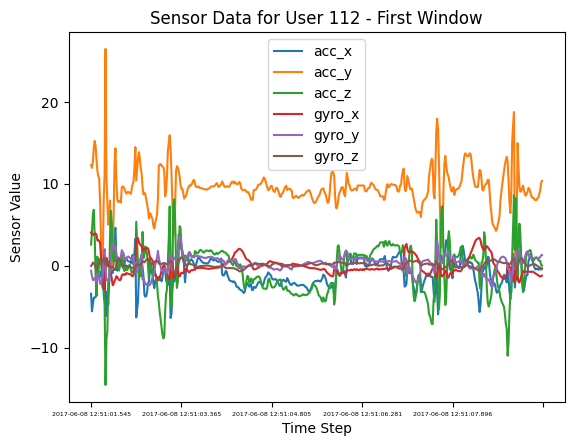

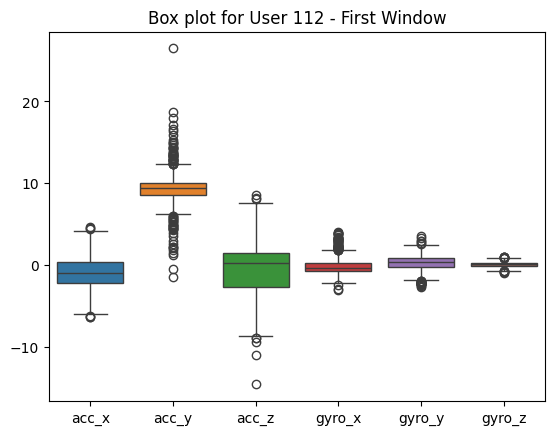

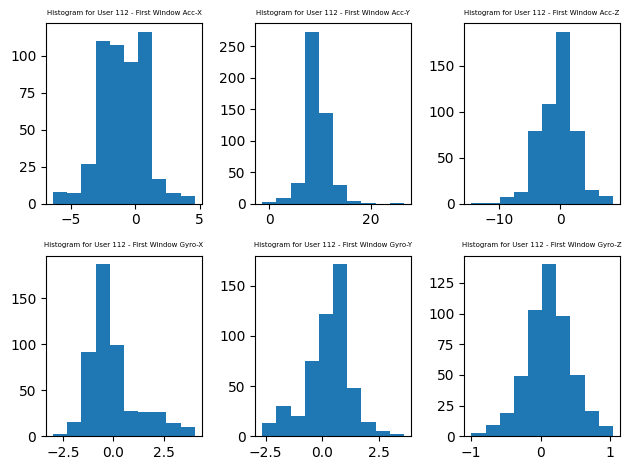

<Figure size 1200x600 with 0 Axes>

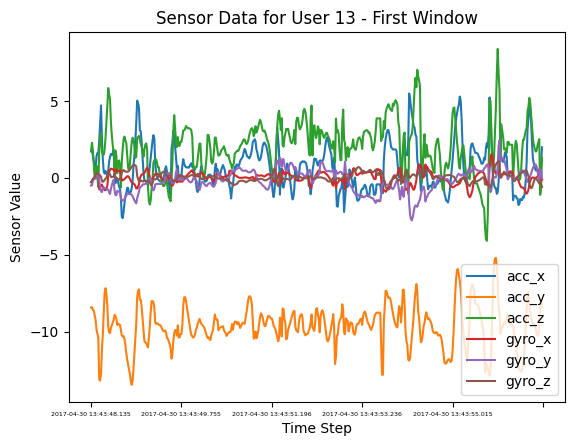

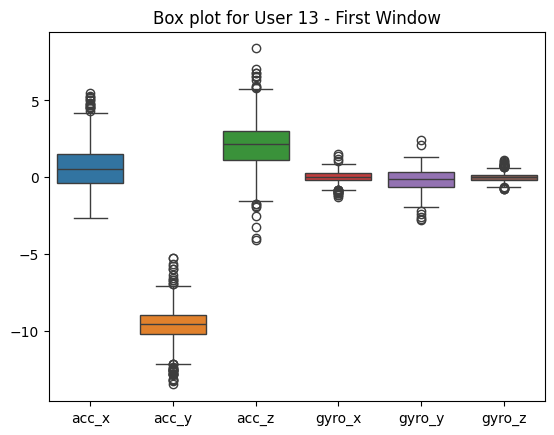

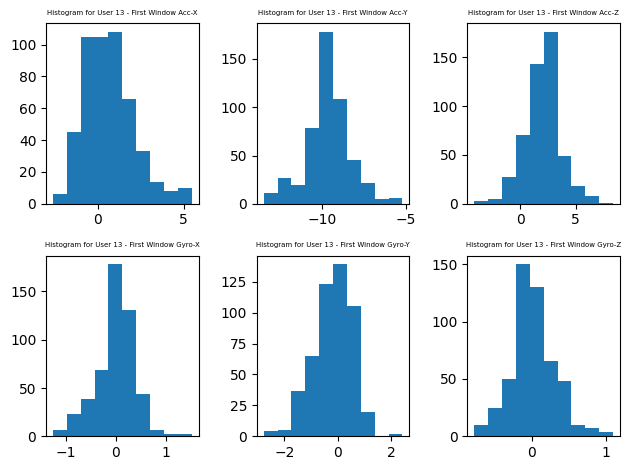

<Figure size 1200x600 with 0 Axes>

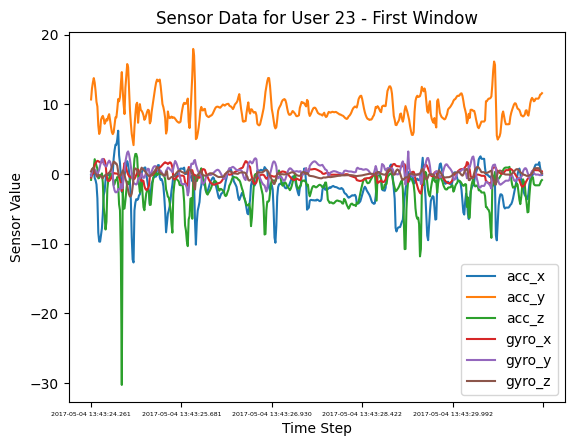

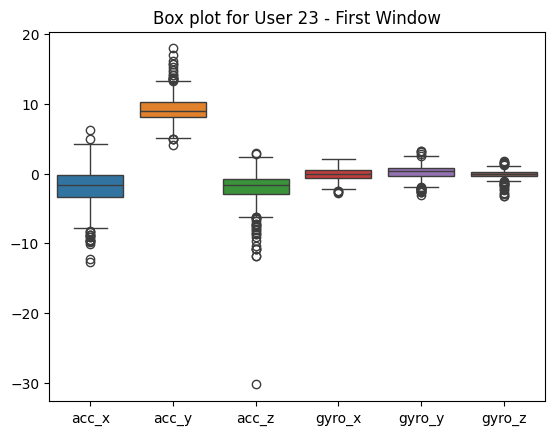

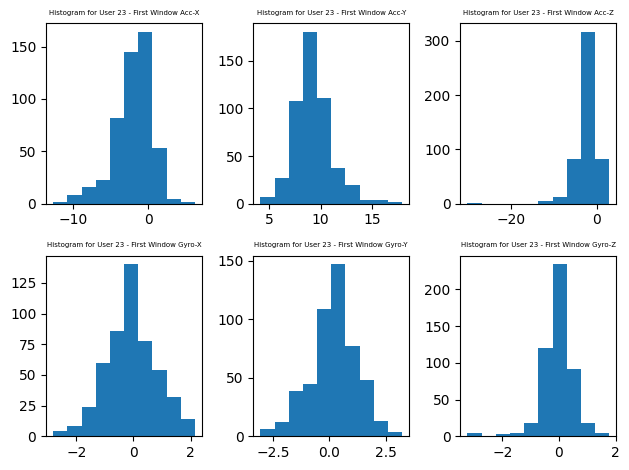

<Figure size 1200x600 with 0 Axes>

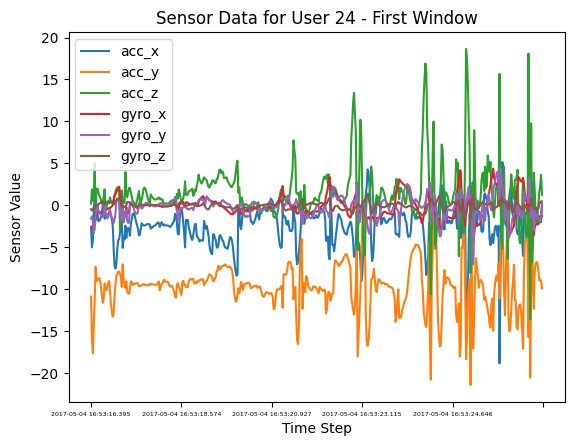

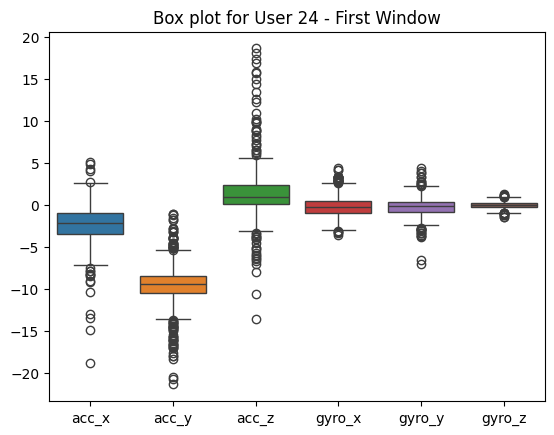

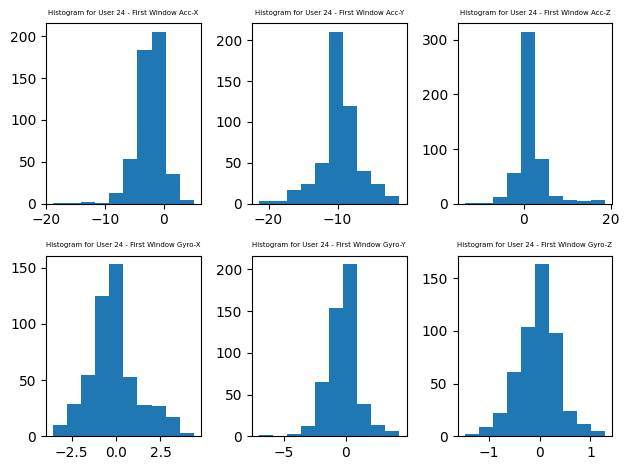

<Figure size 1200x600 with 0 Axes>

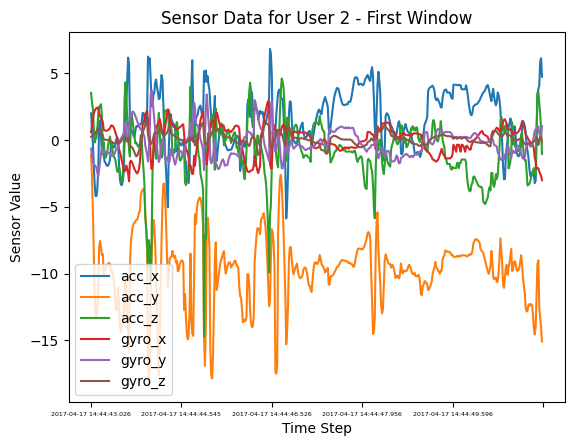

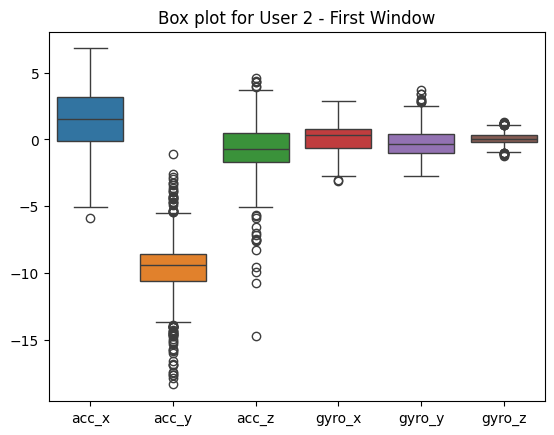

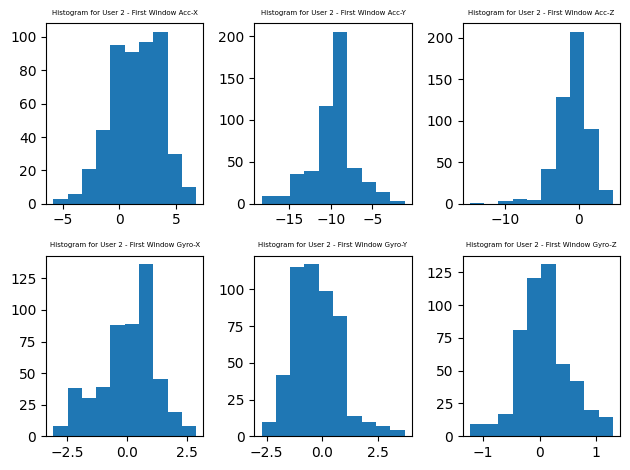

<Figure size 1200x600 with 0 Axes>

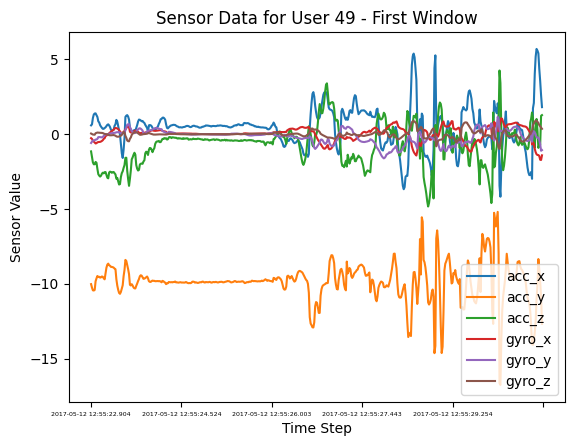

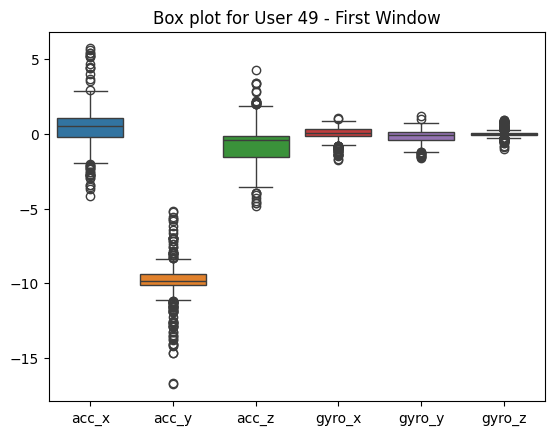

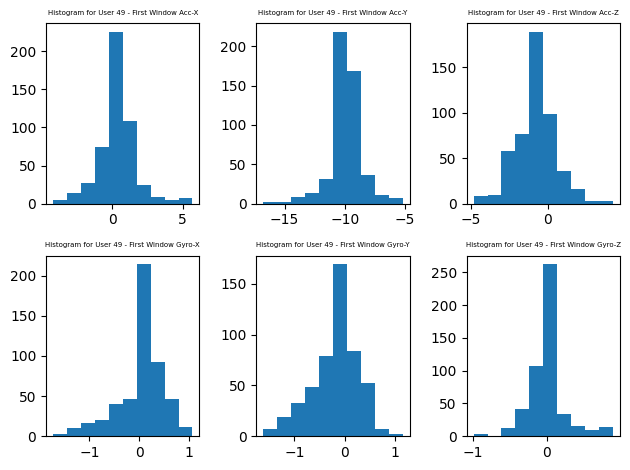

<Figure size 1200x600 with 0 Axes>

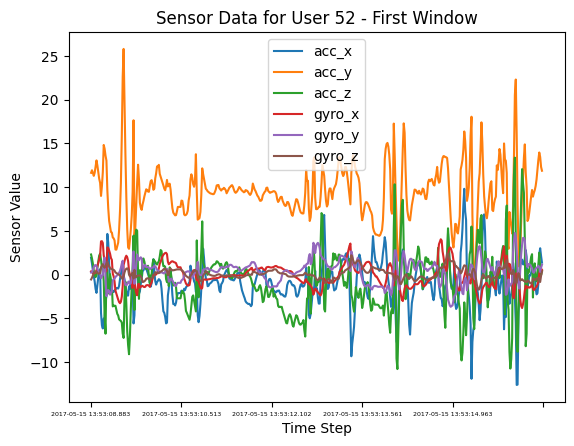

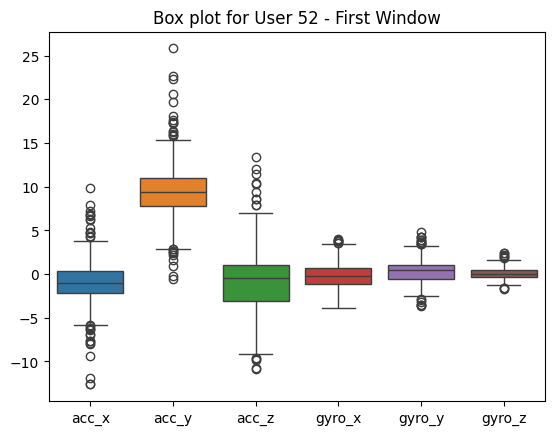

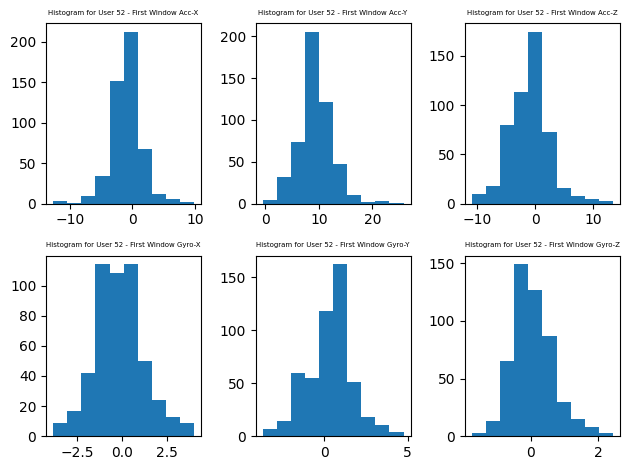

<Figure size 1200x600 with 0 Axes>

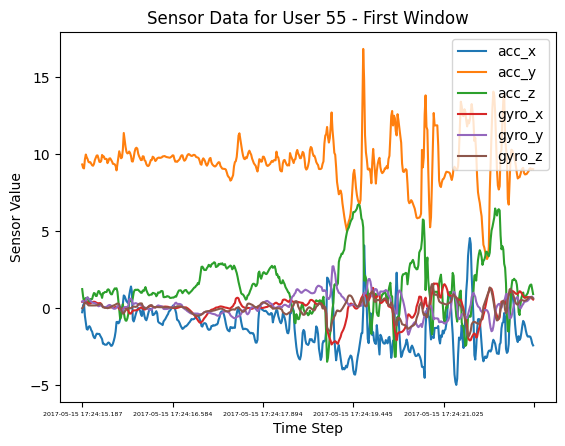

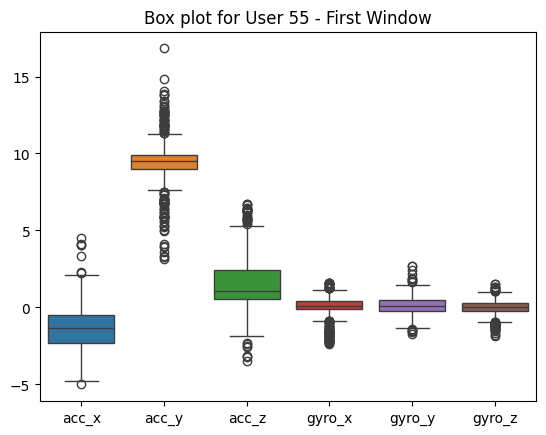

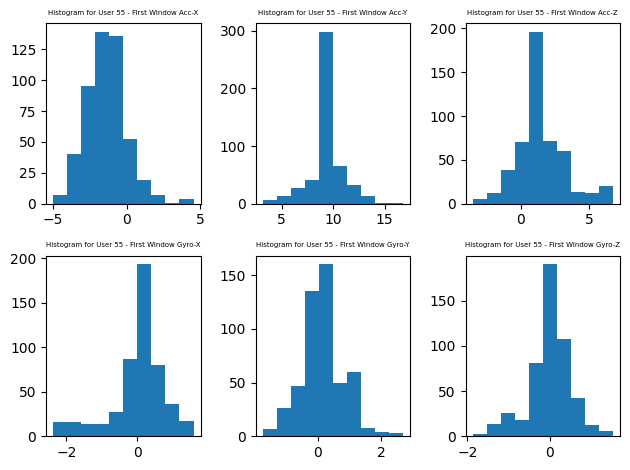

<Figure size 1200x600 with 0 Axes>

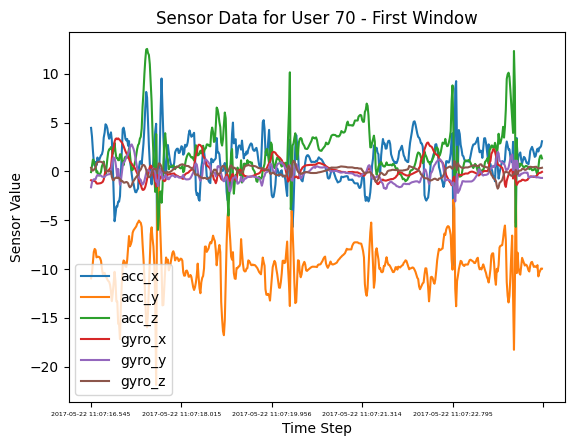

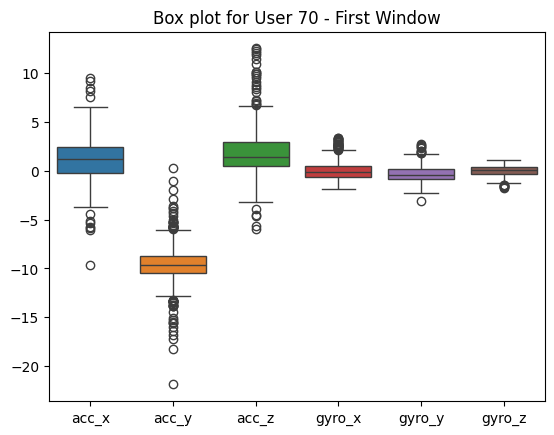

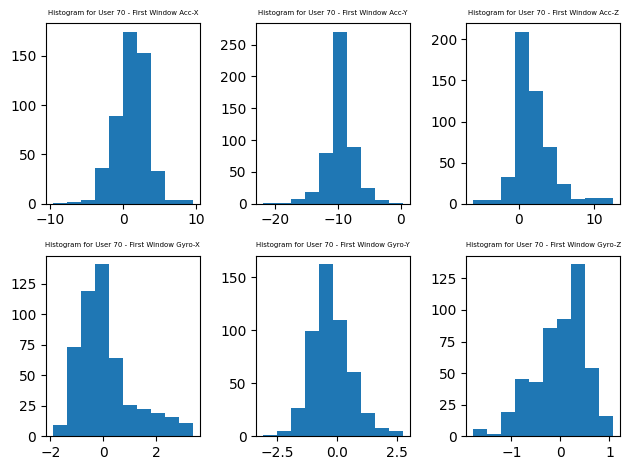

<Figure size 1200x600 with 0 Axes>

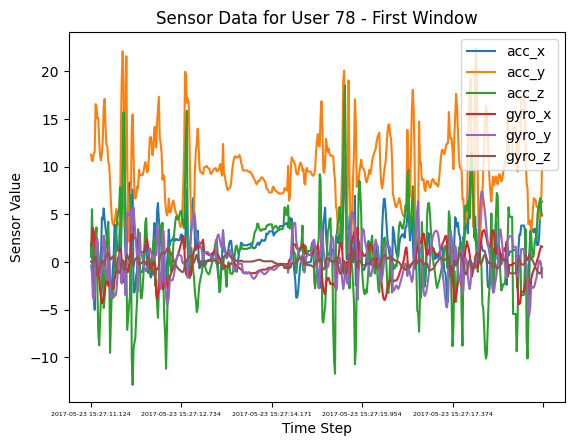

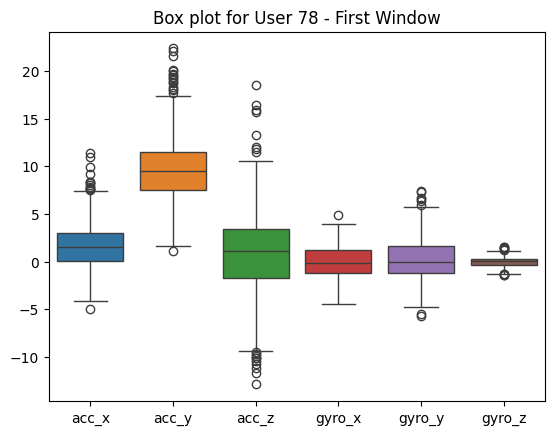

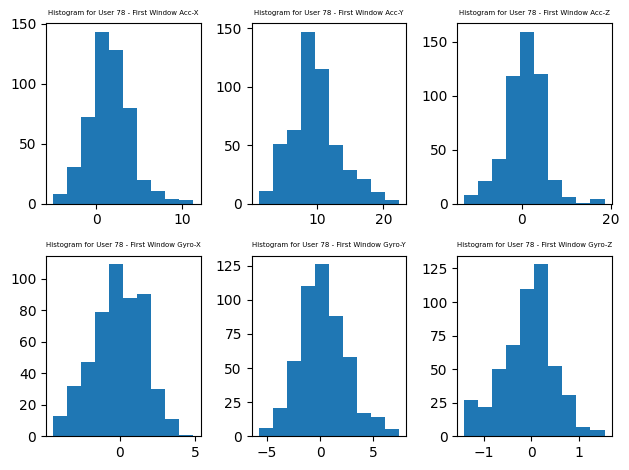

In [ ]:
for user in user_ids:
  #create visualizations for the first window for each user
  first_window = user_windows[user][0]
  #line plots
  plt.figure(figsize=(12, 6))
  first_window.plot(x = 'time',
      y=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
  )
  plt.tick_params(axis='x', labelsize=4.5)
  plt.title(f"Sensor Data for User {user} - First Window")
  plt.xlabel("Time Step")
  plt.ylabel("Sensor Value")
  plt.legend()
  plt.show()

  #box plots to visualize outliers
  sns.boxplot(data = first_window)
  plt.title(f"Box plot for User {user} - First Window")
  plt.show()

  #histograms for each senser value
  fig, axs = plt.subplots(2, 3)

  axs[0, 0].hist(first_window['acc_x'])
  axs[0, 0].set_title(f"Histogram for User {user} - First Window Acc-X", fontsize=5)

  axs[0, 1].hist(first_window['acc_y'])
  axs[0, 1].set_title(f"Histogram for User {user} - First Window Acc-Y", fontsize=5)

  axs[0, 2].hist(first_window['acc_z'])
  axs[0, 2].set_title(f"Histogram for User {user} - First Window Acc-Z", fontsize=5)

  axs[1, 0].hist(first_window['gyro_x'])
  axs[1, 0].set_title(f"Histogram for User {user} - First Window Gyro-X", fontsize=5)

  axs[1, 1].hist(first_window['gyro_y'])
  axs[1, 1].set_title(f"Histogram for User {user} - First Window Gyro-Y", fontsize=5)

  axs[1, 2].hist(first_window['gyro_z'])
  axs[1, 2].set_title(f"Histogram for User {user} - First Window Gyro-Z", fontsize=5)

  plt.tight_layout()
  plt.show()

In [ ]:
#outlier detection and removal using IQR
cleaned_windows = {}
for user_id, list_of_windows in user_windows.items():
    cleaned_list_for_user = []

    for window_df in list_of_windows:
        cleaned_window = window_df.copy()

        for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            Q1 = cleaned_window[col].quantile(0.25)
            Q3 = cleaned_window[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            cleaned_window[col] = cleaned_window[col].clip(lower=lower_bound, upper=upper_bound)

        cleaned_list_for_user.append(cleaned_window)

    cleaned_windows[user_id] = cleaned_list_for_user

In [ ]:
#smoothing using moving average
smoothed_windows = {}
for user_id, list_of_windows in cleaned_windows.items():
    smoothed_list_for_user = []

    for window_df in list_of_windows:
        smoothed_window = window_df.copy()

        for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            smoothed_window[col] = smoothed_window[col].rolling(window=5, center=True).mean()
            smoothed_window[col] = smoothed_window[col].fillna(method='bfill').fillna(method='ffill')

        smoothed_list_for_user.append(smoothed_window)

    smoothed_windows[user_id] = smoothed_list_for_user

/tmp/ipython-input-135720411.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_window[col] = smoothed_window[col].fillna(method='bfill').fillna(method='ffill')


In [ ]:
#feature extraction
def zero_crossing_rate(series):
    return ((series.iloc[:-1] * series.iloc[1:].values) < 0).sum()

def dominant_frequency(series, sampling_rate=100):
    N = len(series)
    yf = rfft(series.values)
    xf = rfftfreq(N, 1 / sampling_rate)
    return xf[np.argmax(np.abs(yf))]

def spectral_entropy(series):
    psd = np.abs(rfft(series.values))**2
    psd_norm = psd / psd.sum()
    return entropy(psd_norm, base=2)

all_features_list = []
channels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

for user_id, list_of_windows in smoothed_windows.items():
    for window_df in list_of_windows:
        features = {}
        for col in channels:
            series = window_df[col]

            features[f'{col}_mean'] = series.mean()
            features[f'{col}_median'] = series.median()
            features[f'{col}_std'] = series.std()
            features[f'{col}_var'] = series.var()
            features[f'{col}_skew'] = series.skew()
            features[f'{col}_kurt'] = series.kurt()
            features[f'{col}_min'] = series.min()
            features[f'{col}_max'] = series.max()
            features[f'{col}_range'] = series.max() - series.min()
            features[f'{col}_q1'] = series.quantile(0.25)
            features[f'{col}_q3'] = series.quantile(0.75)

            rms = np.sqrt(np.mean(series**2))
            features[f'{col}_rms'] = rms
            features[f'{col}_mav'] = series.abs().mean()
            features[f'{col}_mad'] = (series - series.mean()).abs().mean()
            features[f'{col}_zcr'] = zero_crossing_rate(series)
            features[f'{col}_energy'] = np.sum(series**2)
            features[f'{col}_crest_factor'] = series.max() / rms if rms != 0 else 0

            features[f'{col}_dom_freq'] = dominant_frequency(series)
            features[f'{col}_spectral_energy'] = np.sum(np.abs(rfft(series.values))**2)
            features[f'{col}_spectral_entropy'] = spectral_entropy(series)

        features['user_id'] = user_id
        all_features_list.append(features)

features_df = pd.DataFrame(all_features_list)

In [ ]:
#feature selection using SelectKBest to pick the 10 best features
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

all_selected_features = []
channels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

for channel_prefix in channels:
    channel_cols = [col for col in X.columns if col.startswith(channel_prefix)]
    X_channel = X[channel_cols]

    selector = SelectKBest(score_func=f_classif, k=10)
    selector.fit(X_channel, y_encoded)

    selected_cols = X_channel.columns[selector.get_support()]
    all_selected_features.extend(selected_cols)

fnn_df = features_df[all_selected_features].copy()
fnn_df['user_id'] = y.values

In [ ]:
#scaling using StandardScaler
X = fnn_df.drop('user_id', axis=1)
y = fnn_df['user_id']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

Starting Feedforward Neural Network (FNN) Training
Starting Fold 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Starting Fold 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Starting Fold 3/5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Starting Fold 4/5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Starting Fold 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Cross-Validation Training Complete


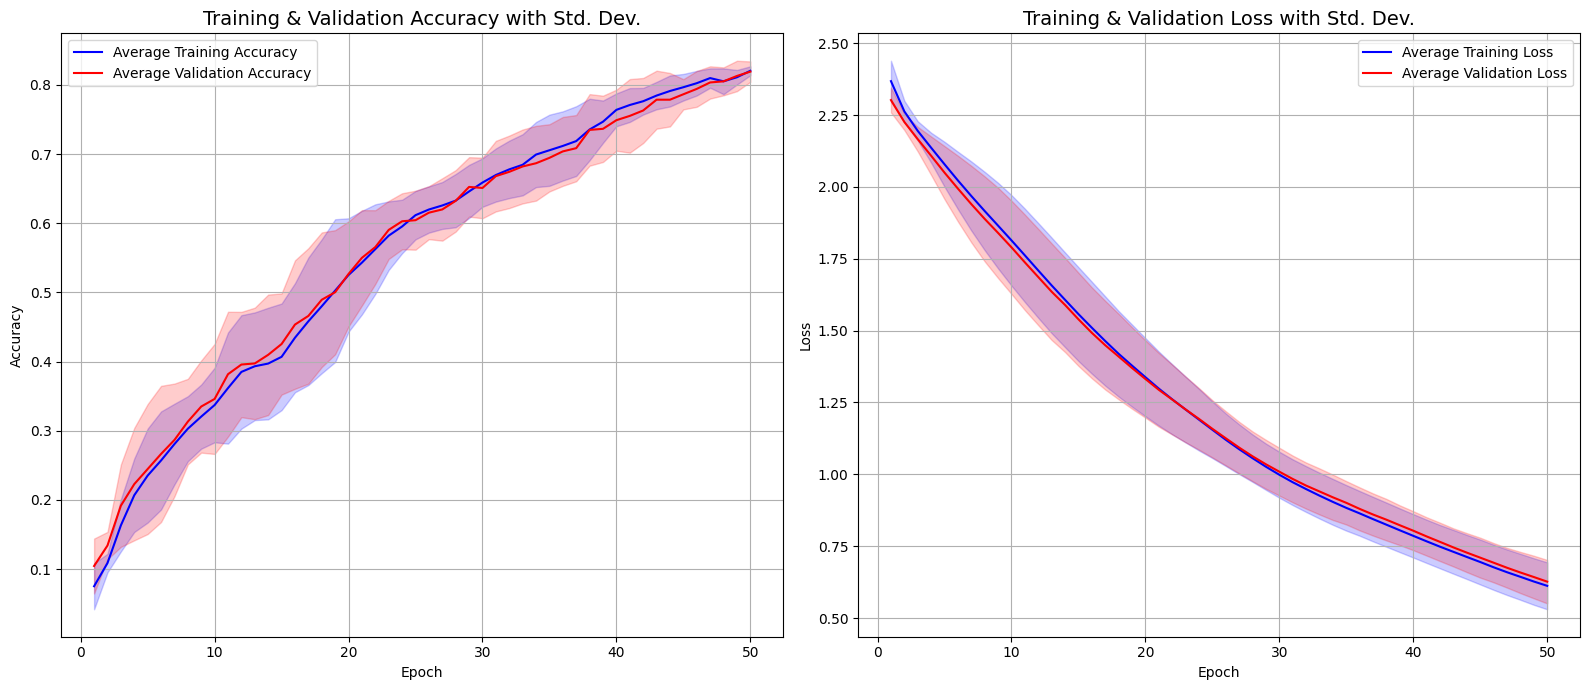

Overall Classification Report
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        59
           1       0.92      1.00      0.96        67
           2       0.83      0.99      0.90        83
           3       0.91      0.67      0.77        73
           4       0.91      0.61      0.73        51
           5       0.89      0.79      0.84        62
           6       0.71      0.95      0.82        63
           7       0.81      0.83      0.82        70
           8       0.72      0.77      0.74        62
           9       0.86      0.98      0.92        52

    accuracy                           0.82       642
   macro avg       0.82      0.81      0.81       642
weighted avg       0.82      0.82      0.81       642

Overall Confusion Matrix


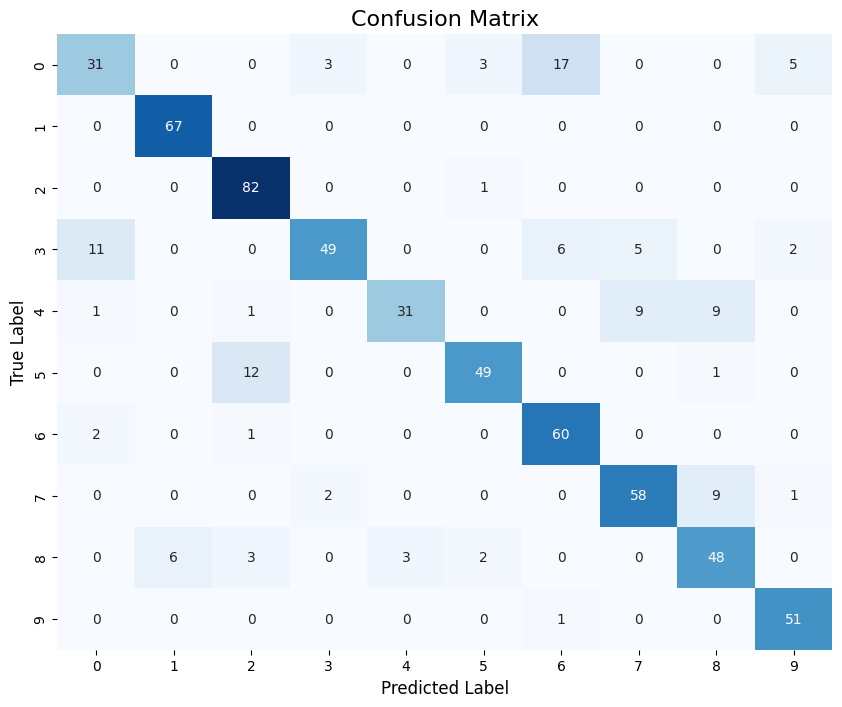

In [ ]:
#FNN Model for user identification
X = X_scaled
y = y_encoded

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_histories = []
all_y_true = []
all_y_pred = []

print("Starting Feedforward Neural Network (FNN) Training")
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Starting Fold {fold+1}/{n_splits}")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    #two hidden layers with 5 neurons each and ReLU activation function
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(5, activation='relu'),
        Dense(5, activation='relu'),
        Dense(10, activation='softmax')
    ])

    #adam optimizer
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        batch_size=32,
                        verbose=0)

    fold_histories.append(history)

    y_pred_probabilities = model.predict(X_val)
    y_pred = np.argmax(y_pred_probabilities, axis=1)

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

print("Cross-Validation Training Complete")

acc = [h.history['accuracy'] for h in fold_histories]
val_acc = [h.history['val_accuracy'] for h in fold_histories]
loss = [h.history['loss'] for h in fold_histories]
val_loss = [h.history['val_loss'] for h in fold_histories]

avg_acc, std_acc = np.mean(acc, axis=0), np.std(acc, axis=0)
avg_val_acc, std_val_acc = np.mean(val_acc, axis=0), np.std(val_acc, axis=0)
avg_loss, std_loss = np.mean(loss, axis=0), np.std(loss, axis=0)
avg_val_loss, std_val_loss = np.mean(val_loss, axis=0), np.std(val_loss, axis=0)

epochs = range(1, len(avg_acc) + 1)

#training and validation accuracy with standard deviation
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_acc, 'b-', label='Average Training Accuracy')
plt.fill_between(epochs, avg_acc - std_acc, avg_acc + std_acc, color='blue', alpha=0.2)
plt.plot(epochs, avg_val_acc, 'r-', label='Average Validation Accuracy')
plt.fill_between(epochs, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, color='red', alpha=0.2)
plt.title('Training & Validation Accuracy with Std. Dev.', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#training and validation loss with standard deviation
plt.subplot(1, 2, 2)
plt.plot(epochs, avg_loss, 'b-', label='Average Training Loss')
plt.fill_between(epochs, avg_loss - std_loss, avg_loss + std_loss, color='blue', alpha=0.2)
plt.plot(epochs, avg_val_loss, 'r-', label='Average Validation Loss')
plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='red', alpha=0.2)
plt.title('Training & Validation Loss with Std. Dev.', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#classification report
print("Overall Classification Report")
print(classification_report(all_y_true, all_y_pred))

#confusion matrix
print("Overall Confusion Matrix")
cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

Starting LSTM Training
Starting Fold 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Starting Fold 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Starting Fold 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Starting Fold 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
Starting Fold 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
Cross-Validation Training Complete


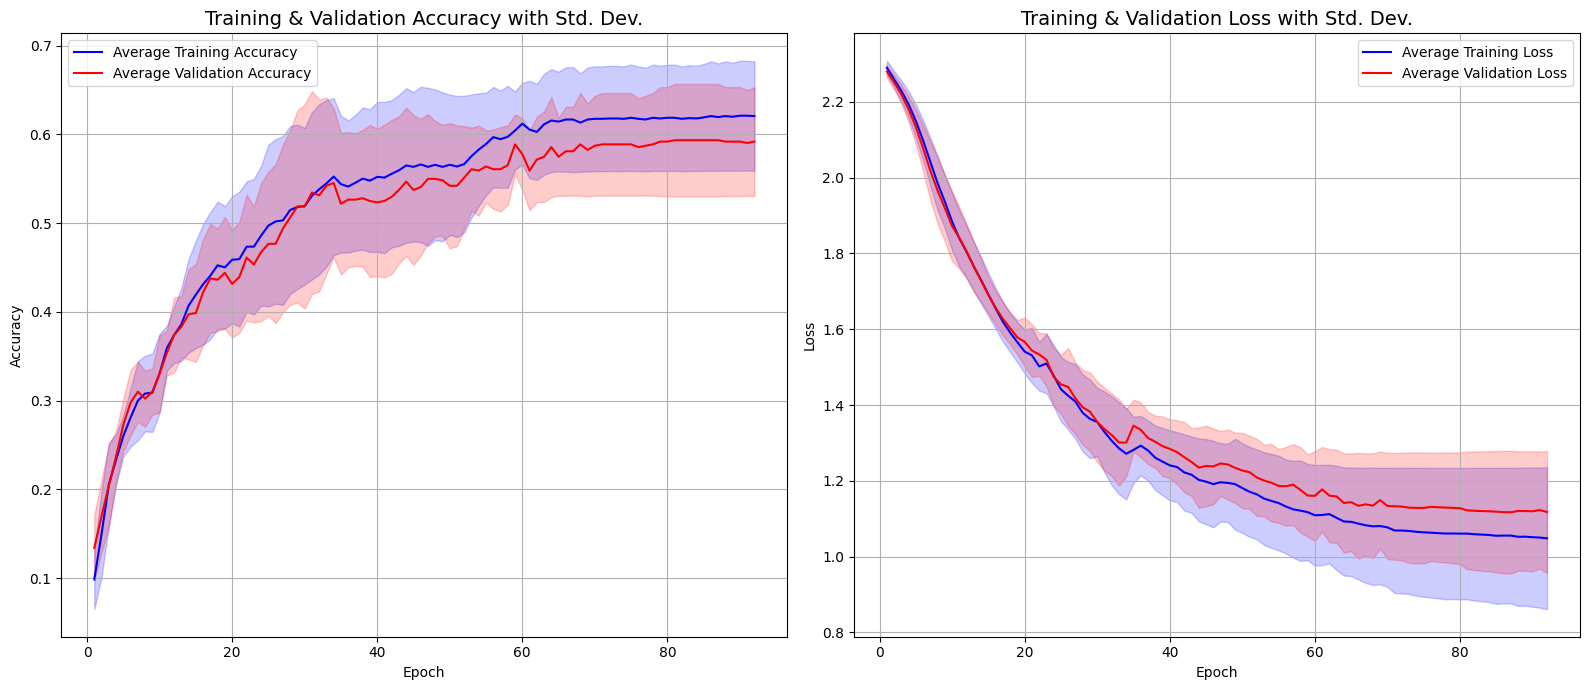

Overall Classification Report
              precision    recall  f1-score   support

           0       0.72      0.22      0.34        59
           1       0.49      0.67      0.57        67
           2       0.64      0.94      0.76        83
           3       0.79      0.63      0.70        73
           4       0.87      0.65      0.74        51
           5       0.79      0.44      0.56        62
           6       0.54      0.71      0.61        63
           7       0.60      0.89      0.72        70
           8       0.66      0.34      0.45        62
           9       0.69      0.81      0.74        52

    accuracy                           0.64       642
   macro avg       0.68      0.63      0.62       642
weighted avg       0.67      0.64      0.62       642

Overall Confusion Matrix


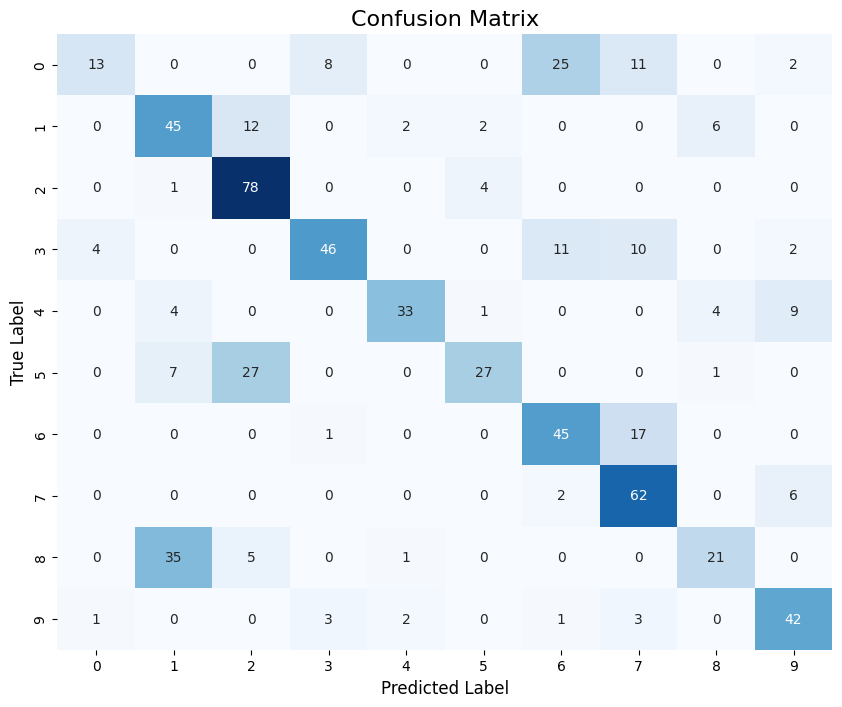

In [ ]:
#LSTM Model for user identification
windows = []
labels = []
sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

for user_id, user_windows in smoothed_windows.items():
    for window_df in user_windows:
        windows.append(window_df[sensor_columns].values)
    labels.extend([user_id] * len(user_windows))

X = np.array(windows)
y = np.array(labels)

#scale the cleaned windows using standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_histories = []
all_y_true = []
all_y_pred = []

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Starting LSTM Training")
for fold, (train_index, val_index) in enumerate(skf.split(X_scaled, y_encoded)):
    print(f"Starting Fold {fold+1}/{n_splits}")

    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    #two LSTM layers with 6 neurons each and tanh activation function
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(6, activation='tanh', return_sequences=True),
        LSTM(6, activation='tanh'),
        Dense(10, activation='softmax')
    ])

    #adam optimizer
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=100,
                        validation_data=(X_val, y_val),
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=0)

    fold_histories.append(history)

    y_pred_probabilities = model.predict(X_val)
    y_pred = np.argmax(y_pred_probabilities, axis=1)

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

print("Cross-Validation Training Complete")

acc = [h.history['accuracy'] for h in fold_histories]
val_acc = [h.history['val_accuracy'] for h in fold_histories]
loss = [h.history['loss'] for h in fold_histories]
val_loss = [h.history['val_loss'] for h in fold_histories]

max_epochs = max(len(h.history['accuracy']) for h in fold_histories)
epochs_range = range(1, max_epochs + 1)

acc_padded = [np.pad(h, (0, max_epochs - len(h)), 'edge') for h in acc]
val_acc_padded = [np.pad(h, (0, max_epochs - len(h)), 'edge') for h in val_acc]
loss_padded = [np.pad(h, (0, max_epochs - len(h)), 'edge') for h in loss]
val_loss_padded = [np.pad(h, (0, max_epochs - len(h)), 'edge') for h in val_loss]

avg_acc, std_acc = np.mean(acc_padded, axis=0), np.std(acc_padded, axis=0)
avg_val_acc, std_val_acc = np.mean(val_acc_padded, axis=0), np.std(val_acc_padded, axis=0)
avg_loss, std_loss = np.mean(loss_padded, axis=0), np.std(loss_padded, axis=0)
avg_val_loss, std_val_loss = np.mean(val_loss_padded, axis=0), np.std(val_loss_padded, axis=0)

#training and validation accuracy with standard deviation
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, avg_acc, 'b-', label='Average Training Accuracy')
plt.fill_between(epochs_range, avg_acc - std_acc, avg_acc + std_acc, color='blue', alpha=0.2)
plt.plot(epochs_range, avg_val_acc, 'r-', label='Average Validation Accuracy')
plt.fill_between(epochs_range, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, color='red', alpha=0.2)
plt.title('Training & Validation Accuracy with Std. Dev.', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#training and validation loss with standard deviation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, avg_loss, 'b-', label='Average Training Loss')
plt.fill_between(epochs_range, avg_loss - std_loss, avg_loss + std_loss, color='blue', alpha=0.2)
plt.plot(epochs_range, avg_val_loss, 'r-', label='Average Validation Loss')
plt.fill_between(epochs_range, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='red', alpha=0.2)
plt.title('Training & Validation Loss with Std. Dev.', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#classification report
print("Overall Classification Report")
print(classification_report(all_y_true, all_y_pred))

#confusion matrix
print("Overall Confusion Matrix")
cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

Training FNN Verification Model for User: 112
User 112 -> AUC: 0.9786, EER: 0.0699


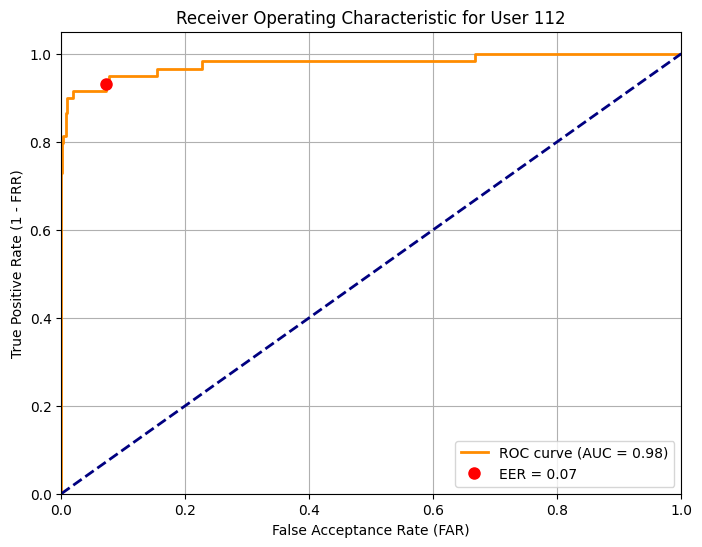

Training FNN Verification Model for User: 13
User 13 -> AUC: 0.9992, EER: 0.0170
Training FNN Verification Model for User: 23
User 23 -> AUC: 0.9999, EER: 0.0018
Training FNN Verification Model for User: 24
User 24 -> AUC: 1.0000, EER: 0.0000
Training FNN Verification Model for User: 2
User 2 -> AUC: 0.9967, EER: 0.0290
Training FNN Verification Model for User: 49
User 49 -> AUC: 0.9833, EER: 0.0676
Training FNN Verification Model for User: 52
User 52 -> AUC: 0.9789, EER: 0.0656
Training FNN Verification Model for User: 55
User 55 -> AUC: 1.0000, EER: 0.0000
Training FNN Verification Model for User: 70
User 70 -> AUC: 0.9976, EER: 0.0308
Training FNN Verification Model for User: 78
User 78 -> AUC: 0.9993, EER: 0.0008
FNN Verification Experiment Complete
Average FAR across all 10 models: 0.1019
Average FRR across all 10 models: 0.2782
Average AUC across all 10 models: 0.9933
Average EER across all 10 models: 0.0283


In [ ]:
#FNN Model for user verification
verification_df = fnn_df.copy()

all_aucs = []
all_eers = []
all_avg_far = []
all_avg_frr = []

for i, target_user in enumerate(user_ids):
    print(f"Training FNN Verification Model for User: {target_user}")

    y = verification_df['user_id'].apply(lambda id: 1 if id == target_user else 0)
    X = verification_df.drop('user_id', axis=1)

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_y_true_for_user = []
    all_y_prob_for_user = []

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        #2 hidden dense layers with 5 neurons each and ReLU activation function
        model = Sequential([
            Input(shape=(X_train_scaled.shape[1],)),
            Dense(5, activation='relu'),
            Dense(5, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        #adam optimizer with binary cross entropy loss function
        model.compile(optimizer='adam', loss='binary_crossentropy')

        model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=0)

        y_pred_prob = model.predict(X_val_scaled, verbose=0).ravel()
        all_y_prob_for_user.extend(y_pred_prob)
        all_y_true_for_user.extend(y_val)

    fpr, tpr, thresholds = roc_curve(all_y_true_for_user, all_y_prob_for_user)

    roc_auc = auc(fpr, tpr)
    all_aucs.append(roc_auc)

    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    all_eers.append(eer)

    all_avg_far.append(np.mean(fpr))
    all_avg_frr.append(np.mean(fnr))

    print(f"User {target_user} -> AUC: {roc_auc:.4f}, EER: {eer:.4f}")

    # ROC for user 112
    if i == 0:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot(fpr[eer_index], tpr[eer_index], 'o', markersize=8, label=f'EER = {eer:.2f}', color='red')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Acceptance Rate (FAR)')
        plt.ylabel('True Positive Rate (1 - FRR)')
        plt.title(f'Receiver Operating Characteristic for User {target_user}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

#average metrics across all users
print("FNN Verification Experiment Complete")
print(f"Average FAR across all 10 models: {np.mean(all_avg_far):.4f}")
print(f"Average FRR across all 10 models: {np.mean(all_avg_frr):.4f}")
print(f"Average AUC across all 10 models: {np.mean(all_aucs):.4f}")
print(f"Average EER across all 10 models: {np.mean(all_eers):.4f}")

Training LSTM Verification Model for User: 112
User 112 -> AUC: 0.9939, EER: 0.0171


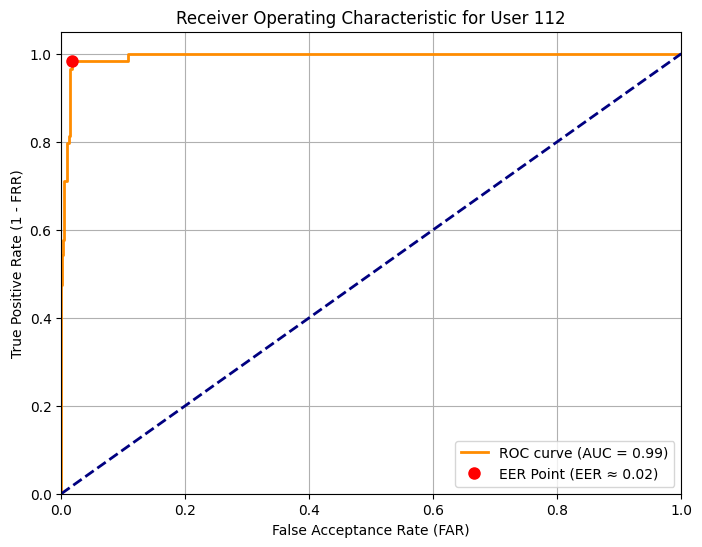

Training LSTM Verification Model for User: 13
User 13 -> AUC: 0.9697, EER: 0.0961
Training LSTM Verification Model for User: 23
User 23 -> AUC: 0.9559, EER: 0.0972
Training LSTM Verification Model for User: 24
User 24 -> AUC: 0.9940, EER: 0.0051
Training LSTM Verification Model for User: 2
User 2 -> AUC: 0.9954, EER: 0.0141
Training LSTM Verification Model for User: 49
User 49 -> AUC: 0.9663, EER: 0.0967
Training LSTM Verification Model for User: 52
User 52 -> AUC: 0.9575, EER: 0.0785
Training LSTM Verification Model for User: 55
User 55 -> AUC: 0.9981, EER: 0.0071
Training LSTM Verification Model for User: 70
User 70 -> AUC: 0.9708, EER: 0.0392
Training LSTM Verification Model for User: 78
User 78 -> AUC: 0.9857, EER: 0.0218
LSTM Verification Experiment Complete
Average FAR across all 10 models: 0.0438
Average FRR across all 10 models: 0.0508
Average AUC across all 10 models: 0.9787
Average EER across all 10 models: 0.0473


In [ ]:
#LSTM Model for user verification
windows = []
labels = []
sensor_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

for user_id, user_windows_list in smoothed_windows.items():
    for window_df in user_windows_list:
        windows.append(window_df[sensor_columns].values)
    labels.extend([user_id] * len(user_windows_list))

X_lstm = np.array(windows)
y_original_labels = np.array(labels)

all_aucs = []
all_eers = []
all_far_at_eer = []
all_frr_at_eer = []

for i, target_user in enumerate(user_ids):
    print(f"Training LSTM Verification Model for User: {target_user}")

    y = np.array([1 if label == target_user else 0 for label in y_original_labels])

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_y_true_for_user = []
    all_y_prob_for_user = []

    for train_index, val_index in skf.split(X_lstm, y):
        X_train, X_val = X_lstm[train_index], X_lstm[val_index]
        y_train, y_val = y[train_index], y[val_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

        #2 LSTM layers with 6 neurons each and tanh activation function
        model = Sequential([
            Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
            LSTM(6, activation='tanh', return_sequences=True),
            LSTM(6, activation='tanh'),
            Dense(1, activation='sigmoid')
        ])

        #adam optimizer and binary cross entropy loss
        model.compile(optimizer='adam', loss='binary_crossentropy')

        model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=0)

        y_pred_prob = model.predict(X_val_scaled, verbose=0).ravel()
        all_y_prob_for_user.extend(y_pred_prob)
        all_y_true_for_user.extend(y_val)

    fpr, tpr, thresholds = roc_curve(all_y_true_for_user, all_y_prob_for_user)
    fnr = 1 - tpr

    roc_auc = auc(fpr, tpr)
    all_aucs.append(roc_auc)

    eer_index = np.nanargmin(np.abs(fnr - fpr))

    far_at_eer = fpr[eer_index]
    frr_at_eer = fnr[eer_index]
    eer = (far_at_eer + frr_at_eer) / 2

    all_far_at_eer.append(far_at_eer)
    all_frr_at_eer.append(frr_at_eer)
    all_eers.append(eer)

    print(f"User {target_user} -> AUC: {roc_auc:.4f}, EER: {eer:.4f}")

    #ROC for user 112
    if i == 0:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot(far_at_eer, tpr[eer_index], 'o', markersize=8, label=f'EER Point (EER ≈ {eer:.2f})', color='red')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Acceptance Rate (FAR)')
        plt.ylabel('True Positive Rate (1 - FRR)')
        plt.title(f'Receiver Operating Characteristic for User {target_user}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

#average metrics for all users
print("LSTM Verification Experiment Complete")
print(f"Average FAR across all 10 models: {np.mean(all_far_at_eer):.4f}")
print(f"Average FRR across all 10 models: {np.mean(all_frr_at_eer):.4f}")
print(f"Average AUC across all 10 models: {np.mean(all_aucs):.4f}")
print(f"Average EER across all 10 models: {np.mean(all_eers):.4f}")